# ResNet

As introduced in "Deep Residual Learning for Image Recognition" by He et al. (2017) [1]. The implementation is based on the torchvision library [2].

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from typing import Optional, List, Tuple, Type, Union

import os, sys
notebook_dir = os.getcwd()
root_path = os.path.abspath(os.path.join(notebook_dir, ".."))
if root_path not in sys.path:
    sys.path.append(root_path)
    print(f"Added {root_path} to sys.path")
    
from Utils.dataloaders import prepare_fashion_mnist
from Utils.little_helpers import timer, set_seed
from Utils.plotting import visualize_test_results, visualize_training_results, visualize_misclassified

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'PyTorch version: {torch.__version__} running on {device}')


PyTorch version: 2.6.0+cu126 running on cuda


## The Degradation Problem
As networks get deeper, they become harder to train, with both training and test accuracy getting worse. This is counterintuitive because a deeper network should be able to represent everything a shallower network can (by making some layers act as identity mappings).

<div align="center">
    <img src="figures/training_error.png" width="750"/>
    <p><i>Figure 1: Training error for plain and residual networks. Source: [1]</i></p>
</div>

Figure 1 shows that in the plain network the deeper 56-layer network has a __higher__ error than the 20-layer network. In residual networks, the deeper 56-layer network has __lower__ error than the 20-layer network. This is a key insight of the paper [1] - residual connections help deeper networks to train better. 

## Understanding Residual Learning

The key insight of ResNet is to reformulate the layers as learning a residual mapping instead of the underlying mapping.
Instead of hoping a stack of layers directly fits a desired mapping H(x), we let these layers fit a residual function F(x) = H(x) - x.
The original mapping becomes F(x) + x, which is implemented with a "shortcut connection" that performs identity mapping and element-wise addition (see Figure 2).

<div align="center">
    <img src="figures/residual_block.png" width="750"/>
    <p><i>Figure 2: Comparison of residual and non-residual blocks</i></p>
</div>

1. If an identity mapping is optimal, it's easier to push the residual to zero than for stacked layers to learn the identity function
2. If the optimal mapping is close to identity, small perturbations are easier to learn than learning from scratch
3. Shortcut connections allow gradient to flow directly through the network, mitigating vanishing gradient problems


### Implementation of ResNet Building Blocks

Let's implement the two types of ResNet building blocks:

1. Basic Block (used in ResNet-18/34)
2. Bottleneck Block (used in ResNet-50/101/152)

In [2]:
class ResidualBlock(nn.Module):
    expansion = 1  # Output channels = in_channels * expansion
    """Basic residual block for ResNet18/34"""
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 stride: int = 1,
                 **kwargs):
        super(ResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3,
                               stride=stride, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3,
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        if stride == 1 and in_channels == out_channels:
            # Identity shortcut - no transformation needed
            self.downsample = nn.Identity()
        else:
            # Projection shortcut - transform input dimensions to match output
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(identity)  # Skip connection
        out = self.relu(out)

        return out

In [3]:
class Bottleneck(nn.Module):
    """Bottleneck block for ResNet50/101/152"""
    expansion = 4  # Output channels = in_channels * expansion
    
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 stride: int = 1, 
                 downsample: Optional[nn.Module] = None,
                 groups: int = 1, 
                 base_width: int = 64, 
                 dilation: int = 1):
        super(Bottleneck, self).__init__()
        
        width = int(out_channels * (base_width / 64.)) * groups
        
        # First 1x1 conv - dimensionality reduction
        self.conv1 = nn.Conv2d(in_channels, width,
                              kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        
        # 3x3 conv - spatial feature extraction
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                              groups=groups, dilation=dilation,
                              padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        
        # Second 1x1 conv - dimensionality expansion
        self.conv3 = nn.Conv2d(width, out_channels * self.expansion,
                              kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        if stride == 1 and in_channels == out_channels * self.expansion:
            # Identity shortcut - no transformation needed
            self.downsample = nn.Identity()
        else:
            # Projection shortcut - transform input dimensions to match output
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        # Dimensionality reduction
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Spatial feature extraction
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        # Dimensionality expansion
        out = self.conv3(out)
        out = self.bn3(out)

        out += self.downsample(identity)  # Skip connection
        out = self.relu(out)

        return out
    

#### Overview:

- Basic Block: 2 layers of 3×3 convolutions
- Bottleneck Block: 1×1 → 3×3 → 1×1 (3 layers)
 
For the bottleneck, the 1×1 convolutions reduce and then restore dimensions:
- First 1×1 reduces dimension from 256 to 64
- 3×3 operates on the reduced dimension
- Last 1×1 increases dimension back to 256

- This design significantly reduces computation while maintaining performance

## Understanding Key ResNet Design Choices

The original ResNet design introduced several important architectural choices:

### Projection Shortcuts vs. Identity Shortcuts

There are three ways to handle shortcuts when dimensions change:
- Option A: Zero-padding identity shortcuts (no extra parameters)
- Option B: Projection shortcuts only when dimensions change
- Option C: Projection shortcuts for all connections

Let's examine the trade-offs:


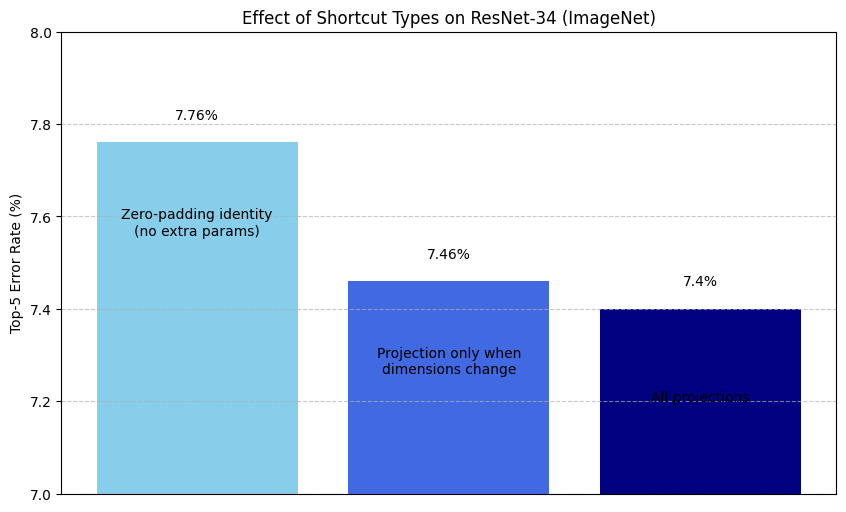

In [4]:
import matplotlib.pyplot as plt

projection_methods = {
    "Option A": "Zero-padding identity\n(no extra params)",
    "Option B": "Projection only when\ndimensions change",
    "Option C": "All projections"
}

error_rates = {
    "Option A": 7.76,
    "Option B": 7.46, 
    "Option C": 7.40
}

plt.figure(figsize=(10, 6))
plt.bar(projection_methods.keys(), error_rates.values(), color=['skyblue', 'royalblue', 'navy'])
plt.ylabel('Top-5 Error Rate (%)')
plt.title('Effect of Shortcut Types on ResNet-34 (ImageNet)')
plt.ylim(7.0, 8.0)  # Zoom in to see the differences

for i, method in enumerate(projection_methods.keys()):
    plt.text(i, error_rates[method] + 0.05, f"{error_rates[method]}%", ha='center')
    plt.text(i, error_rates[method] - 0.2, projection_methods[method], ha='center')

plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

[1] concluded that projections provide small accuracy gains but identity shortcuts are sufficient for addressing the degradation problem and are more memory/computation efficient. 

> Looking at our code: What type of shortcut is used in our building blocks?

## Stochastic Depth with DropPath

In 2016 Huang et al. introduced ["Deep Networks with Stochastic Depth"](https://arxiv.org/abs/1603.09382). It's a regularization technique specifically designed for very deep residual networks

The core idea is beautifully simple: during training, randomly drop entire layers (by skipping the residual branch) with some probability. During inference, use the full network.

### How DropPath works

The `DropPath` module (also called Stochastic Depth) works by:

1. During training, for each batch, randomly dropping the entire residual path (the non-identity branch) of certain blocks with a probability `p`
2. When a path is dropped, the input simply passes through the identity connection
3. When kept, the output is scaled by `1/(1-p)` to maintain the expected value of the output
4. During inference (evaluation mode), no paths are dropped

Here's the core implementation taken from [timm (torch image models)](https://github.com/huggingface/pytorch-image-models):

In [5]:
# Thanks to rwightman's timm package
# github.com:rwightman/pytorch-image-models

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


### Why it works

Stochastic Depth improves deep network training in several ways:

1. **Implicit Network Ensemble**: By randomly dropping different layers, the network effectively becomes an implicit ensemble of networks with varying depths, contributing to better generalization.

2. **Reducing Vanishing Gradients**: With some layers dropped, gradients have shorter paths to flow back during backpropagation, which helps mitigate the vanishing gradient problem.

3. **Improved Information Flow**: By sometimes skipping residual blocks, the network can maintain better information flow from earlier layers to later ones.

4. **Regularization Effect**: The randomness introduced during training prevents the network from relying too heavily on specific layers, forcing it to learn more robust features.

### Implementation Pattern

A common implementation pattern is to gradually increase the drop probability for deeper layers:

- Earlier layers are dropped with lower probability (or not at all)
- Deeper layers are dropped with higher probability

This makes intuitive sense: earlier layers extract more fundamental features that shouldn't be dropped as often, while deeper layers focus on more specialized feature refinement.

With the standard linear scaling approach, if `p` is the maximum drop probability:

```
drop_rate_for_block[i] = p * i / (total_blocks - 1)
```


> Where would you implement the drop path class?

## ResNet implementation



In [6]:
class ResNet(nn.Module):
    def __init__(self, 
                 block: Type[Union[ResidualBlock, Bottleneck]],
                 layers: List[int],
                 num_classes: int = 1000,
                 in_channels: int = 3,
                 zero_init_residual: bool = False,
                 groups: int = 1,
                 width_per_group: int = 64,
                 replace_stride_with_dilation: Optional[List[bool]] = None,
                 return_features: bool = False):
        """
        Generic ResNet implementation that supports basic and bottleneck blocks
        """
        super(ResNet, self).__init__()
        
        self.return_features = return_features
        self.in_channels = 64
        self.dilation = 1
        
        if replace_stride_with_dilation is None:
            # Create a list of False values with same length as layers
            replace_stride_with_dilation = [False] * len(layers)
        else:
            assert len(replace_stride_with_dilation) == len(layers), \
                f"replace_stride_with_dilation should be of length {len(layers)}, but has length {len(replace_stride_with_dilation)}"
            
        self.groups = groups
        self.base_width = width_per_group
        
        # Initial layers - can be adjusted based on input size
        if in_channels == 1:  # grayscale
            self.conv1 = nn.Conv2d(in_channels, self.in_channels, kernel_size=3, 
                                  stride=1, padding=1, bias=False)
        else:  # RGB - For larger inputs like ImageNet
            self.conv1 = nn.Conv2d(in_channels, self.in_channels, kernel_size=7, 
                                  stride=2, padding=3, bias=False)
            
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        
        if in_channels != 1:  # For larger inputs, add maxpool
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.maxpool = nn.Identity()  # No maxpool for small inputs
        
        # Define channel sizes for each layer
        channels = [64, 128, 256, 512, 1024, 2048]  # Support for more layers if needed
        
        # Create ResNet layers using ModuleList for flexibility
        self.layers = nn.ModuleList()
        
        for i, num_blocks in enumerate(layers):
            # Only apply stride=2 from the second layer onwards
            stride = 1 if i == 0 else 2
            
            layer = self._make_layer(
                block=block, 
                out_channels=channels[i], 
                num_blocks=num_blocks, 
                stride=stride,
                dilate=replace_stride_with_dilation[i]
            )
            
            self.layers.append(layer)
            
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Calculate final feature dimension based on architecture
        final_dim = channels[len(layers)-1] * block.expansion
            
        # Classifier
        self.fc = nn.Linear(final_dim, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
        # Zero-initialize the last BN in each residual branch
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, ResidualBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, 
                    block: Type[Union[ResidualBlock, Bottleneck]],
                    out_channels: int, num_blocks: int, stride: int = 1, 
                    dilate: bool = False) -> nn.Sequential:
        previous_dilation = self.dilation
        
        if dilate:
            self.dilation *= stride
            stride = 1
            
        layers = []
        
        # First block may have stride > 1
        layers.append(block(
            in_channels=self.in_channels, 
            out_channels=out_channels, 
            stride=stride, 
            groups=self.groups,
            base_width=self.base_width, 
            dilation=previous_dilation
        ))
        
        # Update in_channels for subsequent blocks
        self.in_channels = out_channels * block.expansion
        
        # Remaining blocks
        for _ in range(1, num_blocks):
            layers.append(block(
                in_channels=self.in_channels, 
                out_channels=out_channels, 
                groups=self.groups,
                base_width=self.base_width, 
                dilation=self.dilation
            ))
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Apply all ResNet layers
        for layer in self.layers:
            x = layer(x)

        x = self.avgpool(x)
        features = torch.flatten(x, 1)
        logits = self.fc(features)
        
        if self.return_features:
            return logits, features
        else:
            return logits


In [7]:
# Function to create ResNet models with different configurations
def create_resnet(model_type: str = None, 
                  block_type: str = 'basic', 
                  num_blocks: List[int] = None, 
                  num_classes: int = 1000,
                  in_channels: int = 3, 
                  return_features: bool = False, 
                  **kwargs) -> ResNet:
    """
    Create a ResNet model based on the specified type or custom configuration
    Returns: ResNet model
    """
    # Predefined configurations
    configs = {
        'resnet18': (ResidualBlock, [2, 2, 2, 2]),
        'resnet34': (ResidualBlock, [3, 4, 6, 3]),
        'resnet50': (Bottleneck, [3, 4, 6, 3]),
        'resnet101': (Bottleneck, [3, 4, 23, 3]),
        'resnet152': (Bottleneck, [3, 8, 36, 3]),
        # Smaller ResNets for smaller datasets
        'resnet20': (ResidualBlock, [3, 3, 3]),
        'resnet32': (ResidualBlock, [5, 5, 5]),
        'resnet44': (ResidualBlock, [7, 7, 7]),
        'resnet56': (ResidualBlock, [9, 9, 9]),
        'resnet_mnist': (ResidualBlock, [2, 2, 2]),
    }
    
    # If model_type is provided, use predefined configuration
    if model_type is not None:
        if model_type not in configs:
            raise ValueError(f"Unsupported model type: {model_type}. "
                           f"Available types: {list(configs.keys())}")
        block, layers = configs[model_type]
    
    # Otherwise, use custom configuration
    else:
        if num_blocks is None:
            raise ValueError("Either model_type or num_blocks must be provided")
        
        if block_type.lower() == 'basic':
            block = ResidualBlock
        elif block_type.lower() == 'bottleneck':
            block = Bottleneck
        else:
            raise ValueError("block_type must be 'basic' or 'bottleneck'")
        
        layers = num_blocks
    
    return ResNet(block, layers, num_classes=num_classes, in_channels=in_channels,
                 return_features=return_features, **kwargs)

## Training Tips

Here are some important considerations when implementing and training ResNets:

#### Batch Normalization 

Batch normalization is applied right after each convolution and before activation:

```python
# Correct structure:
self.conv = nn.Conv2d(...)
self.bn = nn.BatchNorm2d(...)
# In forward:
out = F.relu(self.bn(self.conv(x)))  # BN before ReLU
```

#### Weight Initialization

Proper initialization is crucial for training very deep networks:

```python
# In practice, modern frameworks handle this automatically
# But the original paper used:
for m in self.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
```

## Loading Pre-trained ResNet Models

Torchvision provides pre-trained ResNet models that can be easily loaded and used:

```python
import torchvision.models as models

# Load a pretrained ResNet model (you can choose from several variants)
# Common options: resnet18, resnet34, resnet50, resnet101, resnet152
pretrained_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Print the model architecture to see the structure
print("Model structure summary:")
print(f"Number of parameters: {sum(p.numel() for p in pretrained_resnet.parameters())}")
print("First few layers:")
for name, module in list(pretrained_resnet.named_children())[:4]:
    print(f"{name}: {module}")
```

## Transfer Learning with ResNet

ResNet is commonly used as a backbone for transfer learning in computer vision tasks. Here's how you can use a pre-trained ResNet for a new classification task:

```python
def create_transfer_model(num_classes):
    # Load pre-trained ResNet
    model = models.resnet50(pretrained=True)
    
    # Freeze all the parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the last fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model
```

## Beyond ResNet: Efficient Model Scaling

After exploring ResNet architecture and its implementation, let's look at a more recent advancement in convolutional neural networks: **EfficientNet**. Introduced in 2019 by Tan and Le [2], EfficientNet addresses a key question in neural network design: 

> How do we effectively scale models to achieve better accuracy with limited computational resources?

ResNet showed that deeper networks can be successfully trained through residual connections. However, EfficientNet demonstrates that we need to carefully balance **depth**, **width**, and **resolution** to achieve optimal performance.

### The Problem with Traditional Scaling Methods

Traditional methods for scaling neural networks typically focus on one dimension:

1. **Depth Scaling**: Adding more layers (like going from ResNet-18 to ResNet-50, ResNet-101, etc.)
2. **Width Scaling**: Increasing the number of channels in each layer
3. **Resolution Scaling**: Using higher resolution input images

<div align="center">
    <img src="figures/scaling.PNG" width="750"/>
    <p><i>Figure 3: Model scaling methods. Source: [2]</i></p>
</div>


### Compound Scaling: The Key Insight of EfficientNet

The fundamental insight behind EfficientNet is that **scaling should be done uniformly across all three dimensions** - depth, width, and resolution - rather than just focusing on one dimension.

This is formalized as:
- Depth: $d = \alpha^\phi$
- Width: $w = \beta^\phi$
- Resolution: $r = \gamma^\phi$

Where $\alpha$, $\beta$, $\gamma$ are constants determined by a small grid search, and $\phi$ is the compound coefficient that controls the overall scaling.

Not sure if I should get into detail about the math here, but the key idea is that by scaling all three dimensions uniformly, you can achieve optimal performance across all three dimensions. I think this is enough to understand EfficientNet.

### References

[1] [Deep residual learning for image recognition](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html)
 
[2] [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)

# Train and evaluate model on tiny ImageNet Dataset

https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html

In [8]:
# create ResNet 20

resnet_model = create_resnet(model_type='resnet50', num_classes=200)

# model parameters
print(resnet_model)

# learnable parameters
print(f"Number of trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Identity()
      )
      (1): Bot

### Initialize model